In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from analytics.app.data.load import list_pipelines
from analytics.app.data.transform import dfs_models_and_evals, logs_dataframe, patch_yearbook_time, leaf_stages

%load_ext autoreload
%autoreload 2

/Users/robinholzinger/micromamba/envs/modyn/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# INPUTS
pipelines_dir = Path("/Users/robinholzinger/robin/dev/eth/modyn-sigmod-data/yearbook/triggering/logs_agg")
output_dir = Path("/Users/robinholzinger/robin/dev/eth/modyn-2/.analytics.log/__plots")
assert pipelines_dir.exists()
assert output_dir.exists()

In [3]:
pipelines = list_pipelines(pipelines_dir)
max_pipeline_id = max(pipelines.keys())
pipelines

{32: ('yearbook_mmdalibi_250_0.05_5d', PosixPath('pipeline_32')),
 33: ('yearbook_amounttrigger_10000', PosixPath('pipeline_33')),
 34: ('yearbook_mmdalibi_250_0.05_2d', PosixPath('pipeline_34')),
 35: ('yearbook_mmdalibi_250_0.07_1d', PosixPath('pipeline_35')),
 36: ('yearbook_mmdalibi_250_0.09_1d', PosixPath('pipeline_36')),
 37: ('yearbook_mmdalibi_250_0.07_5d', PosixPath('pipeline_37')),
 38: ('yearbook_mmdalibi_250_0.05_1d', PosixPath('pipeline_38')),
 39: ('yearbook_mmdalibi_250_0.09_2d', PosixPath('pipeline_39')),
 40: ('yearbook_mmdalibi_500_0.05_2d', PosixPath('pipeline_40')),
 41: ('yearbook_mmdalibi_500_0.05_1d', PosixPath('pipeline_41')),
 42: ('yearbook_mmdalibi_250_0.07_2d', PosixPath('pipeline_42')),
 43: ('yearbook_mmdalibi_500_0.05_5d', PosixPath('pipeline_43')),
 44: ('yearbook_mmdalibi_500_0.07_5d', PosixPath('pipeline_44')),
 45: ('yearbook_mmdalibi_500_0.07_2d', PosixPath('pipeline_45')),
 46: ('yearbook_mmdalibi_500_0.09_1d', PosixPath('pipeline_46')),
 47: ('year

In [4]:
from analytics.app.data.load import load_pipeline_logs

pipeline_logs = {p_id: load_pipeline_logs(p_id, pipelines_dir) for (p_id, (_, p_path)) in pipelines.items()}

In [51]:
# mode
pipeline_ids = [54, 68, 80]

# doesn't do anything unless include_composite_model = True
composite_model_variant = "currently_active_model"

patch_yearbook = True
dataset_id = "yearbook_test"
eval_handler = "slidingmatrix"
metric = "Accuracy"
include_composite_model = False
cumulative = False

# Wrangle data

In [52]:
df_leaf_list = []
for pipeline_id in pipeline_ids:
    logs = pipeline_logs[pipeline_id]
    pipeline_leaf_stages = leaf_stages(logs)
    df_all = logs_dataframe(logs, f"pipeline_{pipeline_id}")
    df_leaf_single = df_all[df_all["id"].isin(pipeline_leaf_stages)]
    df_leaf_list.append(df_leaf_single)

df_leaf = pd.concat(df_leaf_list)

In [53]:
df_adjusted = df_leaf.copy()

# coloring in order of decreasing avg. duration
avg_duration_per_stage = df_adjusted.groupby(["pipeline_ref", "id"])["duration"].mean().sort_values(ascending=False)
df_adjusted = df_adjusted.merge(
    avg_duration_per_stage, on=["pipeline_ref", "id"], suffixes=("", "_avg")
).sort_values("duration_avg", ascending=False)

# Yearbook as a mapped time dimension (to display the correct timestamps we need to convert back from days to years)
if patch_yearbook:
    patch_yearbook_time(df_adjusted, "sample_time")

In [54]:
df_adjusted
df_adjusted["sample_time_year"] = df_adjusted["sample_time"].dt.year
df_adjusted["sample_time_year_bin"] = pd.cut(df_adjusted["sample_time_year"], bins=10, labels=False)

In [55]:
df_new = df_adjusted[(
    df_adjusted["id"].isin(
        ["TRAIN", "STORE_TRAINED_MODEL", "INFORM_SELECTOR_REMAINING_DATA", "INFORM_SELECTOR_ABOUT_TRIGGER", "EVALUATE_TRIGGER_POLICY"]
    )
)][["pipeline_ref", "id", "sample_time_year", "duration"]].copy()
df_new = df_new.sort_values("sample_time_year")
df_new["duration"] = df_new["duration"].astype(int)

In [56]:
state_rename = {
    "INFORM_SELECTOR_REMAINING_DATA": "inform remaining data",
    "INFORM_SELECTOR_ABOUT_TRIGGER": "inform trigger",
}

df_new["id"] = df_new["id"].replace(state_rename).str.lower().str.replace("_", " ")

In [57]:
# Create the heatmap
from analytics.plotting.common.common import init_plot
import matplotlib.dates as mdates

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.ticker import MaxNLocator

import pandas as pd

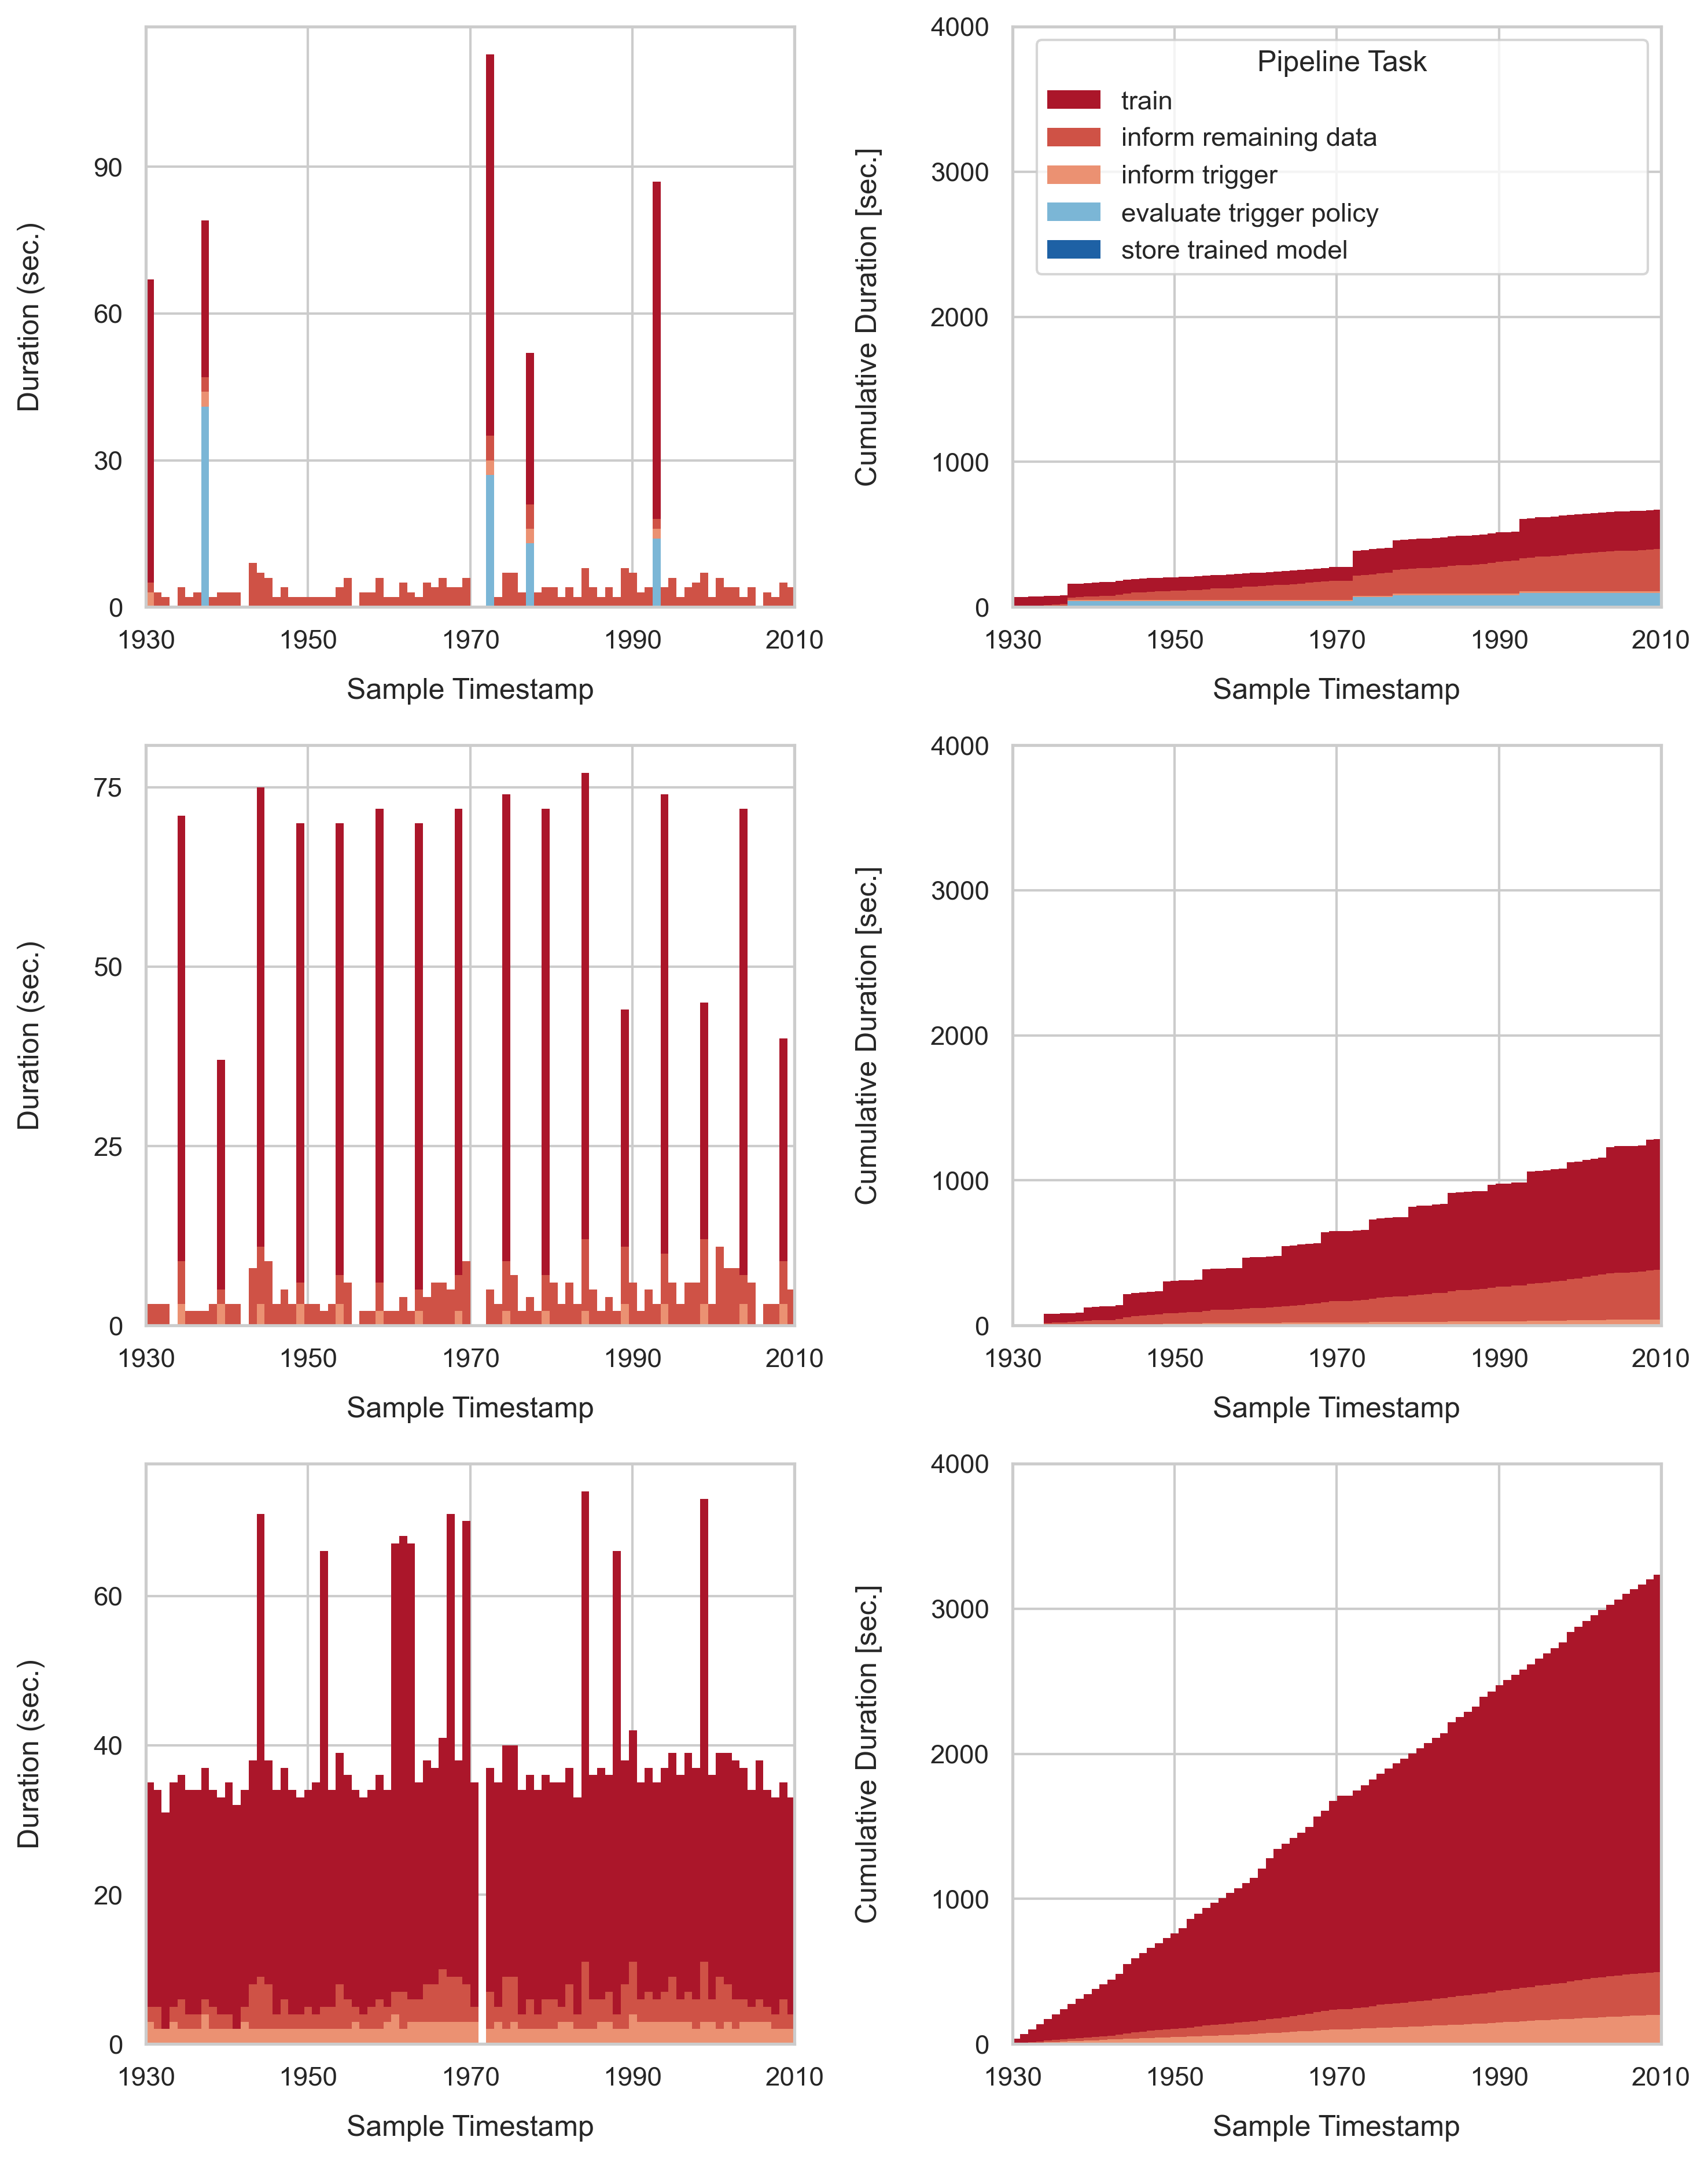

In [82]:
FONTSIZE = 20
DOUBLE_FIG_WIDTH = 10
DOUBLE_FIG_HEIGHT = 3.5

init_plot()
plt.rcParams["svg.fonttype"] = "none"

fig, axs = plt.subplots(
    nrows=len(pipeline_ids),
    ncols=2,
    edgecolor="black",
    frameon=True,
    figsize=(DOUBLE_FIG_WIDTH, 1.2 * DOUBLE_FIG_HEIGHT * len(pipeline_ids)),
    dpi=300,
)

x_col = "sample_time_year"
y_col = "duration"
hue_col = "id"

sns.set_theme(style="whitegrid")
palette = sns.color_palette("RdBu", 10)
palette2 = sns.color_palette("colorblind", 10)
new_palette = [palette[0], palette[1], palette[2], palette[-3], palette[-1]]

# use sum of all pipelines to determine the order of the bars that is consistent across subplots
df_agg = df_new.groupby([hue_col]).agg({y_col: "sum"}).reset_index()
df_agg = df_agg.sort_values("duration", ascending=False)
categories = df_agg[hue_col].unique()

legend_tuple = (pipeline_ids[0], True)

for row, pipeline_id in enumerate(pipeline_ids):
    # sort by cumulative duration
    df_new_pipeline = df_new[df_new["pipeline_ref"] == f"pipeline_{pipeline_id}"]

    for cumulative in [False, True]:
        h = sns.histplot(
            df_new_pipeline,
            x="sample_time_year",
            weights="duration",
            bins=2014-1930+1,
            cumulative=cumulative,
            # discrete=True,
            multiple="stack",
            linewidth=0,  # Remove white edges between bars
            shrink=1.0,    # Ensure bars touch each other
            alpha=1.0,  # remove transparaency

            # hue
            hue="id",
            hue_order=categories,
            palette=new_palette,

            # ax=axs[int(cumulative)],  # for 1 pipeline, only 1 row
            ax=axs[row, int(cumulative)],

            # legend
            legend=legend_tuple == (pipeline_id, cumulative),
        )

        # Set x-axis
        h.set(xlim=(1930, 2010))
        h.set_xlabel("Sample Timestamp", labelpad=10)
        h.set_xticks(
            ticks=[x for x in range(1930, 2010 + 1, 20)],
            labels=[x for x in range(1930, 2010 + 1, 20)],
            rotation=0,
            # ha='right'
        )

        # Set y-axis ticks to be equally spaced
        # h.xaxis.set_major_locator(MaxNLocator(nbins=6))  # Example: 6 ticks on the x-axis

        if cumulative:
            h.set_ylabel("Cumulative Duration [sec.]", labelpad=20)
            yticks = [x for x in range(0, 4000+1, 1000)]
            h.set(ylim=(0, 4000))
            h.set_yticks(
                ticks=yticks,
                labels=yticks,
                rotation=0
            )
        else:
            h.yaxis.set_major_locator(MaxNLocator(nbins=4))  # Example: 4 ticks on the y-axis
            h.set_ylabel("Duration (sec.)", labelpad=20)
            # yticks = [x for x in range(0, 170+1, 40)]

        if legend_tuple == (pipeline_id, cumulative):
            # set hue label
            legend = h.get_legend()

            legend.set_title("")  # remove title

            # expand legend horizontally
            legend.set_bbox_to_anchor((0, 1, 1, 0), transform=h.transAxes)


            # Modify the label texts to add spaces at the end
            for text in legend.get_texts():
                transformed_text = text.get_text() + " " * 35
                text.set_text(transformed_text)
                text.set_linespacing(1.5)

# Display the plot
plt.tight_layout()
plt.show()

for img_type in ["png", "svg"]:
    img_path = output_dir / f"yearbook_cost.{img_type}"
    fig.savefig(img_path, bbox_inches="tight", transparent=True)

# Playground

In [ ]:
# dummy dataframe
df = pd.DataFrame(
    {
        "pipeline_ref": ["A", "A", "A", "A", "A", "A"],
        "id": ["TRAIN", "TRAIN", "TRAIN", "BETA", "BETA", "BETA"],
        "sample_time_year": [1930, 1931, 1932, 1930, 1931, 1932],
        "duration": [1, 5, 3, 2, 2, 6],
    }
)

In [ ]:


stacked_df = df[df["id"].isin(["TRAIN", "BETA"])]
stacked_df["id"] = "BETA"
stacked_df = stacked_df.groupby(["sample_time_year"]).agg(duration=("duration", "sum")).reset_index()
print(stacked_df)

# BETA (alpha virtually added)
plt.bar(
    x=stacked_df["sample_time_year"],
    height=stacked_df["duration"],
    color=new_palette[1],
    width=1.0,
    # facecolor='black',
    edgecolor=new_palette[2],
)


plt.bar(
    x=df[df["id"] == "TRAIN"]["sample_time_year"],
    height=df[df["id"] == "TRAIN"]["duration"],
    color=new_palette[0],
    width=1.0,
    # facecolor='black',
    edgecolor=new_palette[0],
)

# Backup: barplot

In [ ]:
# Create the heatmap
from analytics.plotting.common.common import init_plot
import matplotlib.dates as mdates

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import pandas as pd


init_plot()
# sns.set_theme(style="ticks")
plt.rcParams["svg.fonttype"] = "none"

FONTSIZE = 20
DOUBLE_FIG_WIDTH = 10
DOUBLE_FIG_HEIGHT = 3.5
DOUBLE_FIG_SIZE = (DOUBLE_FIG_WIDTH, 1.5 * DOUBLE_FIG_HEIGHT)

palette = sns.color_palette("RdBu", 10)
palette2 = sns.color_palette("colorblind", 10)

new_palette = palette2
# new_palette = [palette[1], palette[-2], palette2[1], palette2[2]]

fig = plt.figure(
    edgecolor="black",
    frameon=True,
    figsize=DOUBLE_FIG_SIZE,
    dpi=300,
)

def stack_plots(df: pd.DataFrame, x_col: str, y_col: str, hue_col: str) -> None:
    bars = []

    # sort by cumulative duration
    df_agg = df.groupby([hue_col]).agg({y_col: "sum"}).reset_index()
    df = df.sort_values("duration", ascending=True)
    
    categories = df[hue_col].unique()

    sns.set_theme(style="whitegrid")
    for i, cat in enumerate(categories):
        # We have to print every color alone and add all bars that should appear below it
        # Therefore we paint the largest bar that includes all categories first in the background
        # and then remove the bars in descending order.
        # Hence we need to iterate over the categories in reverse order.

        plt.bar(
            x=df[df[hue_col] == cat][x_col],
            height=df[df[hue_col] == cat][y_col],
            color=new_palette[i],
            width=1.0,
            # facecolor='black',
            edgecolor=new_palette[i],
        )
        bars.append( mpatches.Patch(color=new_palette[i], label=cat))

        plt.xlabel("Evaluation Year")
        plt.xticks(
            ticks=[x for x in range(1930, 2010 + 1, 20)],
            labels=[x for x in range(1930, 2010 + 1, 20)],
            rotation=0,
            # ha='right'
        )

    # add legend
    plt.legend(handles=bars)
    plt.show()

stack_plots(df_new, "sample_time_year", "duration", "id")

# Display the plot
plt.tight_layout()
plt.show()